## First Run setup
### Install dependencies

In [1]:
%%capture
%env SUMO_HOME="/usr/share/sumo"
%env LIBSUMO_AS_TRACI='1'

# '''
# Configeration of env path is tested on Google colab, feel free to run it on colab after uploading net files and set your file path.
# But set your enviroment if you would like to run the code on other platform or system.
# '''

!sudo apt-get install sumo sumo-tools sumo-doc
!pip install gymnasium sumo_rl
!pip install traci


In [1]:
import gymnasium as gym
import sumo_rl
import traci
import csv
import numpy as np
import pandas as pd
from copy import deepcopy

In [8]:
'''
Set xmls path for setting enviroment. Replace the file path for your own system.
WARNING: CONNECTION ERROR would be raised if the path is NOT correctlt set!
'''

single_intersection_net_file='nets/single-intersection/single-intersection.net.xml' # net file path
single_intersection_rou_file='nets/single-intersection/single-intersection.rou.xml' # rou file path
grid2x2_net_file='/nets/single-intersection/single-intersection.net.xml' # net file path
grid2x2_rou_file='/nets/single-intersection/single-intersection.rou.xml' # rou file path

# **Agents**

### Regular SARSA

In [4]:
def epsilon_greedy_policy(environment, q_table, state, action_space,epsilon):
    num_actions = environment.action_space.n
    if str(state) not in q_table:
            q_table[str(state)] = [0 for _ in range(num_actions)]
            
    if np.random.rand() < epsilon:
            action = environment.action_space.sample()
    else:
            action = np.argmax(q_table[str(state)])

    return action

def greedy_policy(environment,q_table, state):
    num_actions = environment.action_space.n
    if str(state) not in q_table:
        q_table[str(state)] = [0 for _ in range(num_actions)]
    action = np.argmax(q_table[str(state)])
    return action

q_array_history = []
alpha_history = []

def sarsa(num_seconds, net_file, route_file, out_csv_name='/content/output.csv', alpha=0.1, alpha_factor=0.9995, gamma=0.99, epsilon=0.5):
    '''
    Simulation on SUMO with SARSA 
    '''
    environment = gym.make('sumo-rl-v0',
                    net_file=net_file,
                    route_file=route_file,
                    out_csv_name=out_csv_name,
                    use_gui=False,
                    num_seconds=num_seconds)

    #initial states:
    s  = environment.reset()
#     num_states = environment.observation_space.n
    num_actions = environment.action_space.n
    # Initial Q table

    q_array = {str(s): [0 for _ in range(num_actions)]}
    if str(s) not in q_array:
            q_array[str(s)] = [0 for _ in range(num_actions)]

    q_array_history.append(q_array.copy())
    alpha_history.append(alpha)

    # Update alpha
    if alpha_factor is not None:
        alpha = alpha * alpha_factor

    a = epsilon_greedy_policy(environment,q_array,str(s),environment.action_space, epsilon)

    end = False
    T = []
    v = []
    steps = []
    while not end:
        
        s_, r_,  terminated, truncated, info = environment.step(a)
        a_ = epsilon_greedy_policy(environment,q_array,str(s_),environment.action_space, epsilon)
        if str(s) not in q_array:
            q_array[str(s)] = [0 for _ in range(num_actions)]
        if str(s_) not in q_array:
            q_array[str(s_)] = [0 for _ in range(num_actions)]

        q_array[str(s)][a]  = q_array[str(s)][a]+  alpha*(r_ + gamma*q_array[str(s_)][a_]-q_array[str(s)][a])

        s = s_
        a = a_
        end  = terminated or truncated

        T.append(info['system_total_waiting_time'])
        v.append(info['system_mean_speed'])
        steps.append(info['step'])

    print('waiting_time', np.mean(T), 't_average_speed', np.mean(v))

    environment.close()

    return q_array, T, v, steps

## SARSA($\lambda$)

In [ ]:
class SARSALambdaLearning():
  
    def __init__(self, actions, alpha=0.01, reward_decay=0.9, epsilon=0.9, eligibility_trace_decay=0.9, df=None):
        self.actions = actions
        self.lr = alpha
        self.gamma = reward_decay
        self.epsilon = epsilon
        self.eligibility_trace_decay = eligibility_trace_decay

        # df is a data frame of pretrained Q table
        if df is None:
            self.Q = pd.DataFrame(columns=self.actions, dtype=np.float64)
        else:
            self.Q = df

        # et is our eligibility trace matrix which we are using in q lambda learning approach
        self.et = deepcopy(self.Q)

    def choose_action(self, state):
        self.check_state_exist(state)
        rand = np.random.uniform()
        if rand < self.epsilon:
            # this case we have to select the beast action based on Q table
            # which is the action that has the max value
            state_action = self.Q.loc[state, :]
            state_action = state_action.reindex(np.random.permutation(state_action.index))
            action = state_action.idxmax()
        else:
            #  in this case we let the agent to have some exploration on the environment
            action = np.random.choice(self.actions)
        return action

    def sarsa_lambda(self, state, action, reward, next_state, next_action):
        self.check_state_exist(next_state)
        predict = self.Q.loc[state, action]
        if next_state != 'terminal':
            target = reward + self.gamma * self.Q.loc[next_state, next_action]
        else:
            target = reward

        self.et.loc[state, action] += 1
        # Q update
        self.Q += self.lr * (target - predict) * self.et

        # decay eligibility trace after update
        self.et *= self.gamma * self.eligibility_trace_decay

    def check_state_exist(self, state):
        if state not in self.Q.index.astype(str):
            zero_series = pd.Series([0] * len(self.actions), index=self.Q.columns, name=state)
            self.Q = self.Q.append(zero_series)
            self.et = self.et.append(zero_series)


In [ ]:
def sarsa_lambda(num_seconds, net_file, route_file, out_csv_name='/output.csv',
                alpha=0.1,
                reward_decay=0.9,
                epsilon=0.5,
                eligibility_trace_decay=0.9,
                run=1):
    '''
    train agent with SARSA(lambda) on SUMO enviroment
    Returns the Q-ARRAY for evaluation
    '''
    env = gym.make('sumo-rl-v0',
                    net_file=net_file,
                    route_file=route_file,
                    out_csv_name='output.csv',
                    use_gui=False,
                    num_seconds=num_seconds,
                    )
    
    s, info = env.reset()
    action_indexes = list(range(env.action_space.n))
    q_rl = SARSALambdaLearning(actions=action_indexes, alpha=0.1, reward_decay=0.9, epsilon=epsilon, eligibility_trace_decay=0.9)
    a = q_rl.choose_action(str(s))
    action = env.action_space.sample()
    done = False
    T = []
    v = []
    steps = []

    while not done:

        s_, r, terminated, truncated, info = env.step(action=action)
        action_ = q_rl.choose_action(str(s_))

        q_rl.sarsa_lambda(str(s), action, r, str(s_), action_)
        action = action_
        s = s_

        done = terminated or truncated
        T.append(info['system_total_waiting_time'])
        v.append(info['system_mean_speed'])
        steps.append(info['step'])

    print('waiting_time', np.mean(T), 't_average_speed', np.mean(v))

    env.save_csv(out_csv_name, run)
    env.close()

    return q_rl.Q, T, v, steps

## True Online Sarsa($\lambda$) with Fourier basis



In [15]:
class TrueOnlineSarsaLambdaBasis:

    def __init__(self, state_space, action_space, basis='fourier', min_max_norm=False, alpha=0.0001, lamb=0.9, gamma=0.99, epsilon=0.05, fourier_order=7, max_non_zero_fourier=2):
        self.alpha = alpha
        self.lr = alpha
        self.lamb = lamb
        self.gamma = gamma
        self.epsilon = epsilon

        self.state_space = state_space
        self.state_dim = self.state_space.shape[0]
        self.action_space = action_space
        self.action_dim = self.action_space.n
        self.min_max_norm = min_max_norm

        if basis == 'fourier':
            self.basis = FourierBasis(self.state_space, self.action_space, fourier_order, max_non_zero=max_non_zero_fourier)
            self.lr = self.basis.get_learning_rates(self.alpha)

        self.num_basis = self.basis.get_num_basis()

        self.et = {a: np.zeros(self.num_basis) for a in range(self.action_dim)}
        self.theta = {a: np.zeros(self.num_basis) for a in range(self.action_dim)}

        self.q_old = None
        self.action = None

    def learn(self, state, action, reward, next_state, done):
        phi = self.get_features(state)
        next_phi = self.get_features(next_state)
        q = self.get_q_value(phi, action)
        if not done:
            next_q = self.get_q_value(next_phi, self.get_action(next_phi))
        else:
            next_q = 0.0
        td_error = reward + self.gamma * next_q - q
        if self.q_old is None:
            self.q_old = q

        for a in range(self.action_dim):
            if a == action:
                self.et[a] = self.lamb*self.gamma*self.et[a] + phi -(self.lr*self.gamma*self.lamb*np.dot(self.et[a],phi))*phi
                self.theta[a] += self.lr*(td_error + q - self.q_old)*self.et[a] - self.lr*(q - self.q_old)*phi
            else:
                self.et[a] = self.lamb*self.gamma*self.et[a]
                self.theta[a] += self.lr*(td_error + q - self.q_old)*self.et[a]
        
        self.q_old = next_q
        if done:
            self.reset_traces()

    def get_q_value(self, features, action):
        return np.dot(self.theta[action], features)
        
    def get_features(self, state):
        if self.min_max_norm:
            state = (state - self.state_space.low) / (self.state_space.high - self.state_space.low)
        return self.basis.get_features(state)
    
    def reset_traces(self):
        self.q_old = None
        for a in range(self.action_dim):
            self.et[a].fill(0.0)
    
    def act(self, obs):
        features = self.get_features(obs)
        return self.get_action(features)

    def get_action(self, features):
        if np.random.rand() < self.epsilon:
            return self.action_space.sample()
        else:
            q_values = [self.get_q_value(features, a) for a in range(self.action_dim)]
            return q_values.index(max(q_values))

In [17]:
def true_online_sarsa(num_seconds, net_file, route_file, out_csv_name='/output.csv',
               alpha=0.1,
               gamma=0.99,
               epsilon=0.5,
               fourier_order=7,
               lamb=0.95,
               run=1):
    '''
    train agent with SARSA on SUMO enviroment
    Returns the Q-ARRAY for evaluation
    '''
    env = gym.make('sumo-rl-v0',
                    net_file=net_file,
                    route_file=route_file,
                    out_csv_name='output.csv',
                    use_gui=False,
                    num_seconds=num_seconds)
    
    obs, info = env.reset()

    agent = TrueOnlineSarsaLambdaBasis(env.observation_space,
                                  env.action_space,
                                  alpha=alpha,
                                  gamma=gamma,
                                  epsilon=epsilon,
                                  fourier_order=fourier_order,
                                  lamb=lamb)
    done = False
    T = []
    v = []
    steps = []
    while not done:
        action = agent.act(obs)
        next_obs, r, terminated, truncated, info = env.step(action=action)
        agent.learn(state=obs, action=action, reward=r, next_state=next_obs, done=done)
        obs = next_obs
        done = terminated or truncated
        T.append(info['system_total_waiting_time'])
        v.append(info['system_mean_speed'])
        steps.append(info['step'])

    print('waiting_time', np.mean(T), 't_average_speed', np.mean(v))

    env.save_csv(out_csv_name, run)
    env.close()

    return agent.theta, T, v, steps

def evaluate_true_online_sarsa(theta, num_seconds, net_file, route_file, out_csv_name='output.csv',
                        alpha=0.1,
                        gamma=0.99,
                        epsilon=0.5,
                        fourier_order=7,
                        lamb=0.95,
                        run=1):
    '''
    Evaluate agent with SARSA on SUMO enviroment
    Returens the Q-ARRAY for evaluation
    '''
    env = gym.make('sumo-rl-v0',
                    net_file=net_file,
                    route_file=route_file,
                    out_csv_name=out_csv_name,
                    use_gui=False,
                    num_seconds=num_seconds)
    
    obs, info = env.reset()

    agent = TrueOnlineSarsaLambdaBasis(env.observation_space,
                                  env.action_space,
                                  alpha=alpha,
                                  gamma=gamma,
                                  epsilon=epsilon,
                                  fourier_order=fourier_order,
                                  lamb=lamb)
    agent.theta = theta

    done = False
    T = []
    v = []
    steps = []
    while not done:
        action = agent.act(obs)
        next_obs, r, terminated, truncated, info = env.step(action=action)
        agent.learn(state=obs, action=action, reward=r, next_state=next_obs, done=done)
        obs = next_obs
        done = terminated or truncated
        T.append(info['system_total_waiting_time'])
        v.append(info['system_mean_speed'])
        steps.append(info['step'])

    print('waiting_time', np.mean(T), 't_average_speed', np.mean(v))

    env.save_csv(out_csv_name, run)
    env.close()

    return agent.theta, T, v, steps

In [ ]:
'''
################################################
### Execute this cell to close tunnel api if crashed ###
################################################
'''
# env.close()
# traci.close() 

'\n################################################\n### Execute this cell to close tunnel api if crashed ###\n################################################\n'

### basis

In [23]:
class Basis:

    def __init__(self, state_space, action_space):
        self.state_space = state_space
        self.action_space = action_space
        self.state_dim = state_space.shape[0]
        self.action_dim = self.action_space.n
    
    def get_features(self, state):
        pass

    def get_num_basis(self) -> int:
        pass

### fourier

In [24]:
from itertools import combinations, product

class FourierBasis(Basis):

    def __init__(self, state_space, action_space, order, max_non_zero=2):
        super().__init__(state_space, action_space)
        self.order = order
        self.max_non_zero = min(max_non_zero, state_space.shape[0])
        self.coeff = self._build_coefficients()
    
    def get_learning_rates(self, alpha):
        lrs = np.linalg.norm(self.coeff, axis=1)
        lrs[lrs==0.] = 1.
        lrs = alpha/lrs
        return lrs
    
    def _build_coefficients(self):
        coeff = np.array(np.zeros(self.state_dim))  # Bias

        for i in range(1, self.max_non_zero + 1):
            for indices in combinations(range(self.state_dim), i):
                for c in product(range(1, self.order + 1), repeat=i):
                    coef = np.zeros(self.state_dim)
                    coef[list(indices)] = list(c)
                    coeff = np.vstack((coeff, coef))
        return coeff
    
    def get_features(self, state):
        return np.cos(np.dot(np.pi*self.coeff, state))

    def get_num_basis(self) -> int:
        return len(self.coeff)

# Comparatitive study between regular SARSA, SARSA($\lambda$) and True Online SARSA 


 Retrying in 1 seconds
 Retrying in 1 seconds


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


waiting_time 193.45771144278606 t_average_speed 3.552443423522953
 Retrying in 1 seconds
 Retrying in 1 seconds


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


waiting_time 69.05472636815921 t_average_speed 5.273778454893319
 Retrying in 1 seconds
 Retrying in 1 seconds


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


waiting_time 46.61194029850746 t_average_speed 5.584464890066745


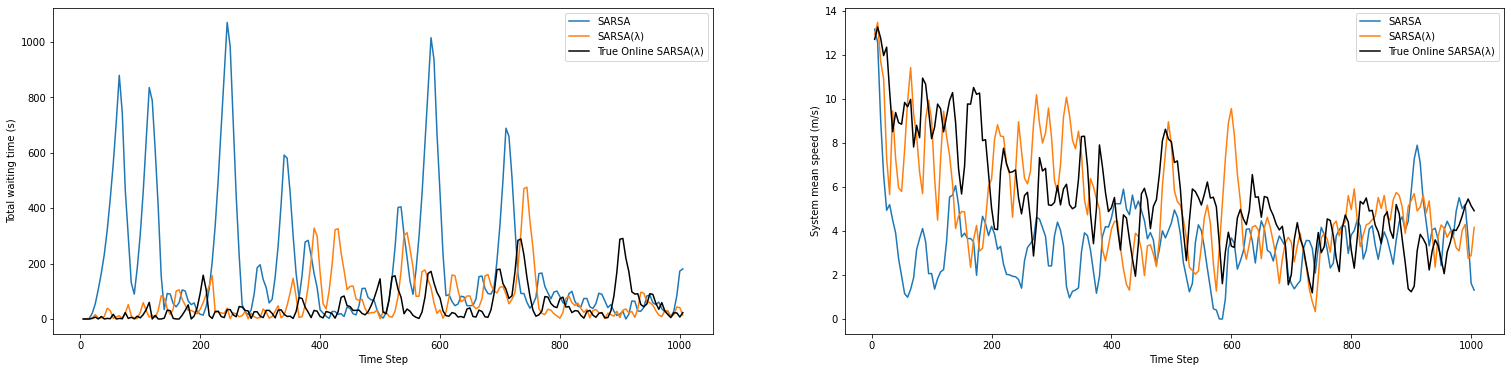

In [ ]:
# %%capture
alpha=0.005
gamma=0.99
epsilon=0.5


q_array, T_sarsa, v_sarsa, steps_sarsa = sarsa(num_seconds=1000,
                                                net_file=single_intersection_net_file,
                                                route_file=single_intersection_rou_file,
                                                alpha=alpha,
                                                alpha_factor=0.9995,
                                                gamma=gamma,
                                                epsilon=epsilon)

q_arrayLmbd, T_sarsaLmbd, v_sarsaLmbd, steps_sarsaLmbd =  sarsa_lambda(num_seconds=1000,
                                                       net_file=single_intersection_net_file,
                                                       route_file=single_intersection_rou_file,
                                                        alpha=alpha,
                                                        reward_decay=0.9,
                                                        epsilon=epsilon,
                                                        eligibility_trace_decay=0.9,
                                                        run=1)

theta_1000, T_TO_sarsa, v_TO_sarsa, steps_TO_sarsa = true_online_sarsa(num_seconds=1000,
                                                    net_file=single_intersection_net_file,
                                                    route_file=single_intersection_rou_file,
                                                    alpha=alpha,
                                                    gamma=gamma,
                                                    epsilon=epsilon)

from matplotlib import pyplot as plt
plt.figure(figsize=(26,6))
plt.subplot(1,2,1)
plt.plot(steps_sarsa, T_sarsa, label='SARSA')
plt.plot(steps_sarsaLmbd, T_sarsaLmbd, label='SARSA(λ)')
plt.plot(steps_TO_sarsa, T_TO_sarsa, 'black', label='True Online SARSA(λ)')
plt.xlabel('Time Step')
plt.ylabel('Total waiting time (s)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(steps_sarsa, v_sarsa, label='SARSA')
plt.plot(steps_sarsaLmbd, v_sarsaLmbd, label='SARSA(λ)')
plt.plot(steps_TO_sarsa, v_TO_sarsa, 'black',label='True Online SARSA(λ)')
plt.xlabel('Time Step')
plt.ylabel('System mean speed (m/s)')
plt.legend()
plt.show()

## Impact of the choice of a reward function

## Instructions to replicate realistic reward

Modify your sumo-rl environment locally.

Find the traffic_signal.py file and add the following to it.

Add a variable in the init of the trafficsignal class 
self.waiting_penalty =0.85

Copy the code in the next cell into the traffic signal class


In [ ]:
def _realistic_reward(self):
        return self.waiting_penalty * self._diff_waiting_time_reward()+(1-self.waiting_penalty)*self._average_speed_reward()

Add realistic_reward to the reward functions dictionary towards the end of this code file as in the next cell and save the changes

In [ ]:
reward_fns = {
        'diff-waiting-time': _diff_waiting_time_reward,
        'average-speed': _average_speed_reward,
        'pressure': _pressure_reward,
        'realistic': _realistic_reward
    }
    

## Run environment with realistic reward

1. Run the command : python3 experiments/sarsa_double.py
2. After, the run is complete, a csv file would be generated in outputs/double/ directory. 
Rename it after each run  so you can distinguish among them
3. Change the reward function of the sumo-environment by passing the argument reward_fn to Sumo-Environment: the accepted functions are
    ['diff-waiting-time','pressure','average-speed','realistic']
4.Repeat step 2 for all of the reward functions
5.Plot the results of the csv files using the code below.    

In [64]:
import matplotlib.pyplot as plt

In [65]:
file_1 = pd.read_csv('../outputs/double/sarsa-double_conn0_run1-waiting.csv')
file_2 = pd.read_csv('../outputs/double/sarsa-double_conn0_run1-average-speed.csv')
file_3 = pd.read_csv('../outputs/double/sarsa-double_conn0_run-realistic.csv')
file_4 = pd.read_csv('../outputs/double/sarsa-double_conn0_run1.csv')

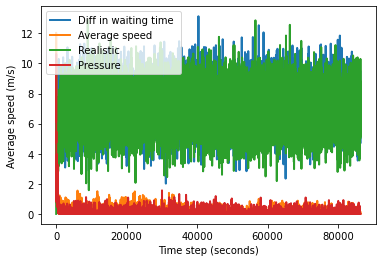

In [66]:
plt.plot(file_1['step'], file_1['system_mean_speed'], label='Diff in waiting time ',linewidth=2)
plt.plot(file_2['step'], file_2['system_mean_speed'], label='Average speed',linewidth=2)
plt.plot(file_3['step'], file_3['system_mean_speed'], label='Realistic',linewidth=2)
plt.plot(file_4['step'], file_4['system_mean_speed'], label='Pressure',linewidth=2)

plt.xlabel('Time step (seconds)')
plt.ylabel('Average speed (m/s)')

plt.legend()
plt.show()

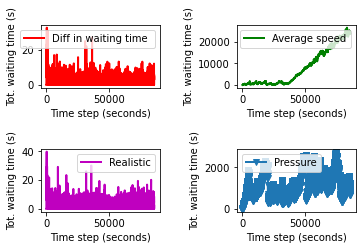

In [67]:
fig, ax = plt.subplots(2, 2)
fig.tight_layout(pad=4.0)
ax[0,0].plot(file_1['step'], file_1['system_mean_waiting_time'], '-r',label='Diff in waiting time ',linewidth=2)
ax[0,0].set_xlabel('Time step (seconds)')
ax[0,0].legend()
ax[0,0].set_ylabel('Tot. waiting time (s)')

ax[0,1].plot(file_2['step'], file_2['system_mean_waiting_time'],'-g', label='Average speed' ,linewidth=2)
ax[0,1].set_xlabel('Time step (seconds)')
# plt.('Time step (seconds)')
ax[0,1].set_ylabel('Tot. waiting time (s)')
ax[0,1].legend()
# plt.subplot(2, 2, 3)
ax[1,0].plot(file_3['step'], file_3['system_mean_waiting_time'],'-m', label='Realistic',linewidth=2)
ax[1,0].set_xlabel('Time step (seconds)')
ax[1,0].set_ylabel('Tot. waiting time (s)')
ax[1,0].legend()
#plt.subplot(2, 2, 4)
ax[1,1].plot(file_4['step'], file_4['system_mean_waiting_time'], '-v',label='Pressure',linewidth=2)
ax[1,1].set_xlabel('Time step (seconds)')
ax[1,1].set_ylabel('Tot. waiting time (s)')
ax[1,1].legend()
plt.show()